In [1]:
import numpy as np 
import gym
import ray
import ray.rllib.agents.ppo as ppo
from ray import tune
import pandas as pd
import GPUtil

from gym import Env, spaces

pd.options.display.max_rows = 12

#get a matrix of distances between locations
df = pd.read_csv('dist_vologda_matrix.csv', sep=',')
df = df.iloc[:, 1:]

#some parameters
working_hours = 12
truck_speed = 60
m = 2

df = df / 1000
df

/home/basilshim/anaconda3/envs/rl_gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


АЗС №35400 Кичменгский Городок  АЗС №35401 Великий Устюг-1  \
0                           0.0000                     99.2272   
1                          99.0684                      0.0000   
2                         101.8148                      5.0688   
3                         139.2135                    134.6791   
4                         154.2522                    149.7178   
..                             ...                         ...   
59                        611.7861                    582.6174   
60                        605.7962                    576.6275   
61                        607.1467                    577.9779   
62                        504.6641                    475.4954   
63                        477.9958                    448.8271   

    АЗС №35402 Великий Устюг-2  АЗС №35403 Дунай  АЗС №35404 Нюксеница  \
0                     101.8513          139.2135              154.2522   
1                       4.9465          134.5201              149.5589   
2                       0.0000          137.2665              152.3053   
3                     137.3031            0.0000               15.0961   
4                     152.3419           15.0961                0.0000   
..                         ...               ...                   ...   
59                    585.2414          447.9957              448.3214   
60                    579.2515          442.0057              442.3315   
61                    580.6020          443.3562              443.6820   
62                    478.1194          340.8736              341.1994   
63                    451.4511          314.2054              314.5311   

    АЗС №35405 Борисово-Судское  АЗС №35406 Журавлево  АЗС №35407 Грязовец-1  \
0                      777.2635              102.4328               520.5020   
1                      748.0318                5.5280               491.2703   
2                      750.7781                3.0302               494.0166   
3                      613.5690              137.8846               356.8075   
4                      613.8947              152.9234               357.1332   
..                          ...                   ...                    ...   
59                     191.2351              585.8229               181.8523   
60                     185.0682              579.8330               175.8624   
61                     186.4186              581.1835               177.2129   
62                     274.3706              478.7009                74.7303   
63                     309.7443              452.0327                46.7818   

    АЗС №35408 Грязовец-2  АЗС №35409 Савино  ...  \
0                517.8863           266.7014  ...   
1                488.6546           241.7276  ...   
2                491.4010           244.4739  ...   
3                354.1918           107.2648  ...   
4                354.5176           107.5905  ...   
..                    ...                ...  ...   
59               179.2367           345.2112  ...   
60               173.2467           339.2213  ...   
61               174.5972           340.5717  ...   
62                72.1146           238.0892  ...   
63                44.1662           211.4209  ...   

    АЗС №35454 Октябрьский пр.-1 (Вологда)  \
0                                 610.3886   
1                                 581.1570   
2                                 583.9033   
3                                 446.6942   
4                                 447.0199   
..                                     ...   
59                                 10.1276   
60                                  6.8726   
61                                  8.2230   
62                                107.4957   
63                                142.8694   

    АЗС №35455 Октябрьский пр.-2 (Вологда)  АЗС №35456 Маяковская  \
0                                 610.3028               607.3283   
1                                

In [2]:
#remove locations, which cannot be served in 12 hours (driver can't get there and come back in 12 hours)
to_remove = ((2 * (df.values[-1,:] / truck_speed) < working_hours) == False).nonzero()[0]
df = df.drop(df.index[to_remove])
df = df.drop(df.columns[to_remove], axis=1)
df = df.reset_index(drop=True)
df

АЗС №35403 Дунай  АЗС №35404 Нюксеница  АЗС №35405 Борисово-Судское  \
0             0.0000               15.0961                     613.5690   
1            15.0961                0.0000                     613.8947   
2           615.1980              615.5238                       0.0000   
3           356.1259              356.4516                     349.7479   
4           353.5507              353.8764                     347.1727   
..               ...                   ...                          ...   
51          447.9957              448.3214                     191.2351   
52          442.0057              442.3315                     185.0682   
53          443.3562              443.6820                     186.4186   
54          340.8736              341.1994                     274.3706   
55          314.2054              314.5311                     309.7443   

    АЗС №35407 Грязовец-1  АЗС №35408 Грязовец-2  АЗС №35409 Савино  \
0                356.8075               354.1918           107.2648   
1                357.1332               354.5176           107.5905   
2                349.0547               346.4390           512.4135   
3                  0.0000                 3.7018           253.3414   
4                  3.7422                 0.0000           250.7662   
..                    ...                    ...                ...   
51               181.8523               179.2367           345.2112   
52               175.8624               173.2467           339.2213   
53               177.2129               174.5972           340.5717   
54                74.7303                72.1146           238.0892   
55                46.7818                44.1662           211.4209   

    АЗС №35410 Сазоново-1  АЗС №35411 Сазоново-2  АЗС №35412 Вытегра  \
0                619.0077               618.5201            629.3182   
1                619.3335               618.8458            629.6440   
2                142.9597               142.4720            165.8965   
3                355.1867               354.6990            373.5276   
4                352.6115               352.1238            370.9524   
..                    ...                    ...                 ...   
51               196.6738               196.1861            332.9386   
52               190.5069               190.0192            326.9487   
53               191.8574               191.3697            328.2991   
54               279.8093               279.3216            346.5072   
55               315.1830               314.6953            329.8897   

    АЗС №35413 Липник  ...  АЗС №35454 Октябрьский пр.-1 (Вологда)  \
0            472.6696  ...                                446.6942   
1            472.9954  ...                                447.0199   
2            193.2966  ...                                187.4480   
3            216.8790  ...                                182.8731   
4            214.3038  ...                                180.2979   
..                ...  ...                                     ...   
51           176.2900  ...                                 10.1276   
52           170.3001  ...                                  6.8726   
53           171.6506  ...                                  8.2230   
54           189.8586  ...                                107.4957   
55           173.2411  ...                                142.8694   

    АЗС №35455 Октябрьский пр.-2 (Вологда)  АЗС №35456 Маяковская  \
0                                 446.6083               443.6339   
1                                 446.9341               443.9596   
2                                 187.3622               184.7850   
3                                 182.7873               179.8128   
4                                 180.2120               177.2376   
..                                     ...                    ...   
51                                 10.0417                 7.

In [3]:
from numpy.random import default_rng

#shrink array
df = df.iloc[45:56,45:56]
#rng = default_rng()
# idx = rng.choice(len(df.values[0])-1, size=len(df.values[0]) - 1 - 10, replace=False)
# df = df.drop(df.index[idx])
# df = df.drop(df.columns[idx], axis=1)
#df = df.reset_index(drop=True)
N = len(df.values[0])
print(N)
df

11


АЗС №35453 Рыбинская  АЗС №35454 Октябрьский пр.-1 (Вологда)  \
45                0.0000                                  2.9073   
46                3.8633                                  0.0000   
47                2.7249                                  0.1930   
48                7.3699                                  4.8380   
49                9.5775                                  7.0456   
50                7.9102                                  5.3783   
51               12.6594                                 10.1276   
52                9.4044                                  6.8726   
53               10.7549                                  8.2230   
54              101.1411                                107.4957   
55              136.5147                                142.8694   

    АЗС №35455 Октябрьский пр.-2 (Вологда)  АЗС №35456 Маяковская  \
45                                  4.0806                 7.4125   
46                                  1.2456                 4.5775   
47                                  0.0000                 4.6982   
48                                  4.7522                 0.0000   
49                                  6.9598                 4.2148   
50                                  5.2924                 4.2618   
51                                 10.0417                 7.2967   
52                                  6.7867                 3.8122   
53                                  8.1372                 5.1627   
54                                107.4099               104.4354   
55                                142.7836               139.8091   

    АЗС №35457 Краснодонцев  АЗС №35458 Северсталь  АЗС №35459 Олимпийская  \
45                   9.7250                 8.2541                 12.5206   
46                   6.8899                 5.4190                  9.6855   
47                   7.0106                 5.5397                  9.8063   
48                   4.5237                 4.0223                  7.3193   
49                   0.0000                 7.7422                  3.8768   
50                   7.8787                 0.0000                 10.6744   
51                   3.3719                10.8241                  0.0000   
52                   4.8070                 7.5691                  6.8095   
53                   3.5396                 8.9196                  5.5422   
54                 106.1650               108.1923                108.1676   
55                 141.5387               143.5660                143.5413   

    АЗС №35460 Северное шоссе-1  АЗС №35461 Северное шоссе-2  \
45                       9.5258                      11.0128   
46                       6.6907                       8.1778   
47                       6.8114                       8.2985   
48                       3.4359                       4.9229   
49                       5.1279                       3.6375   
50                       7.5253                       9.0124   
51                       6.1623                       4.6720   
52                       0.0000                       1.5045   
53                       1.5229                       0.0000   
54                     101.3755                     102.8626   
55                     136.7492                     138.2363   

    АЗС № 35462 Аксеново  Нефтебаза  
45              101.0346   136.0123  
46              107.1799   142.1575  
47              107.3006   142.2782  
48              103.9250   138.9026  
49              105.4997   140.4774  
50              108.0145   142.9921  
51              107.2118   142.1894  
52              101.2218   136.1995  
53              102.5723   137.5500  
54                0.0000    35.0674  
55               35.4634     0.0000

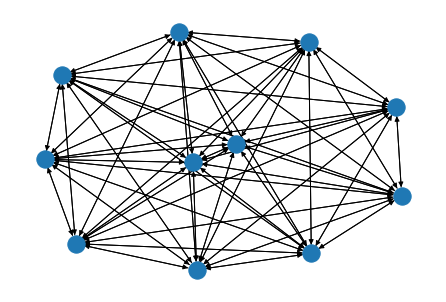

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_numpy_matrix(df.values, create_using=nx.DiGraph)
nx.draw(G)
plt.show()

In [5]:
#custom gym environment for our problem
m = 2
N = len(df.values[0])
working_hours = 12
truck_speed = 60

class TransportScape(Env):
    def __init__(self, env_config):
        self.num_of_trucks = m
        self.num_of_locations = N
        self.h = working_hours #working hours of each truck driver
        self.speed = truck_speed
        self.distances = df.values #an array, containing distances between locations
    
        self.action_space = spaces.MultiDiscrete([self.num_of_trucks, self.num_of_locations - 1])
    
        self.observation_space = spaces.Dict(
        {
            #x_i - shows each truck's location
            'truck location': spaces.MultiDiscrete(np.full(self.num_of_trucks, self.num_of_locations)),
            #p_j - shows whether a truck is assigned to this particular location or not
            'assignment': spaces.MultiBinary(self.num_of_locations - 1), 
            #u_i - shows whether a particular truck was used before
            'truck usage': spaces.MultiBinary(self.num_of_trucks),
            #delta_i - shows how much time each truck has left until the end of the work day
            'time left': spaces.Box(low=np.zeros(self.num_of_trucks), high=np.full(self.num_of_trucks, self.h), dtype=np.float64)
        })
        self.reset()
        
    def nice_print(self):
        print("Truck Location")
        print(self.state['truck location'])
        print("Assignment")
        print(self.state['assignment'])
        print("Truck Usage")
        print(self.state['truck usage'])
        print("Time Left")
        print(self.state['time left'])
        
    def reset(self):
        self.state = {'truck location': np.full(self.num_of_trucks, self.num_of_locations - 1),
                      'assignment': np.zeros(self.num_of_locations - 1),
                      'truck usage': np.zeros(self.num_of_trucks),
                      'time left': np.full(self.num_of_trucks, self.h)}
        self.done = False
        return self.state 
    
    def step(self, action):
        i, j = action[0], action[1]
        truck_loc = self.state['truck location']
        assignment = self.state['assignment']
        truck_use = self.state['truck usage']
        time_left = self.state['time left']
        
        #if a truck is already assigned to this location - penalty
        if assignment[j] == 1:
            self.reward = -6000
        #if no time left - penalty
        elif (time_left[i] - self.distances[truck_loc[i], j] / self.speed - self.distances[j, -1] / self.speed) < 0:
            self.reward = -6000
        #else - assign truck to a new location
        else:
            self.reward = 0
            #print("else")
            #if needs to use an unused before truck - penalty
            if truck_use[i] == 0:
                self.reward = -2000
                truck_use[i] = 1
            assignment[j] = 1
            self.reward -= self.distances[truck_loc[i], j]
            time_left[i] -= self.distances[truck_loc[i], j] / self.speed - 0.5
            truck_loc[i] = j
        #if all locations have trucks assigned to them - end episode
        if np.all(assignment == 1):
            self.done = True
        else:
            self.done = False
        
        self.state['truck location'] = truck_loc
        self.state['assignment'] = assignment
        self.state['truck usage'] = truck_use
        self.state['time left'] = time_left
        
        return self.state, self.reward, self.done, {}

In [7]:
config = ppo.DEFAULT_CONFIG.copy()
config["env_config"] = {}
config["num_workers"] = 1
config["framework"] = "torch"
#config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['kl_coeff'] = 0.0 #можно поменять
config["log_level"] = "ERROR"
config['num_gpus'] = 0
#config['learning_rate'] = 0.0001

In [62]:
ray.shutdown()
ray.init()

2022-05-28 01:30:34,398	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.8.13', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '192.168.1.72', 'raylet_ip_address': '192.168.1.72', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-05-28_01-30-32_192193_54937/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-05-28_01-30-32_192193_54937/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-05-28_01-30-32_192193_54937', 'metrics_export_port': 58851, 'gcs_address': '192.168.1.72:55277', 'address': '192.168.1.72:55277', 'node_id': '6f0acb0fa457b1f8d2f89259e186ae9118cc6d736b32b453d41017c8'})

In [63]:
agent = ppo.PPOTrainer(config=config, env=TransportScape)

In [18]:
import datetime
print(datetime.datetime.now())
#i = 0
episodes = 0
#while episodes <= 150000:
for i in range(50):
    result = agent.train()
    if i % 10 == 0:
        print('i: ', i)
        print('mean episode length:', result['episode_len_mean'])
        print('max episode reward:', result['episode_reward_max'])
        print('mean episode reward:', result['episode_reward_mean'])
        print('min episode reward:', result['episode_reward_min'])
        print('total episodes:', result['episodes_total'])
        episodes = result['episodes_total']
        checkpoint = agent.save()
    i += 1
print(datetime.datetime.now())

2022-05-27 17:04:16.929287
(scheduler +1m18s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


KeyboardInterrupt: 

In [ ]:
env = TransportScape(config)
state = env.reset()
g = 0
done = False
reward = 0
actions = []
i = 0
while not done:
    action = agent.compute_action(state, explore = False)
    actions.append(action)
    print("action: {:}; reward: {:}".format(action, reward))
    state, reward, done, info = env.step(action)
    g += reward
    i += 1
    if i == 1000:
        break
print("Final state:")
print("Assignment:", state['assignment'])
print("Trucks used:", state['truck usage'])
print("Time left", state['time left'])
print(g) 

In [ ]:
truck_paths = {}
for k, v in actions:
    truck_paths.setdefault(k,[]).append(v)
for k in truck_paths:
    print("Truck #{:}: {:}".format(k,truck_paths[k]))

In [48]:
ray.shutdown()
ray.init()

2022-05-27 19:06:25,366	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.8.13', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '192.168.1.72', 'raylet_ip_address': '192.168.1.72', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-05-27_19-06-23_271292_54937/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-05-27_19-06-23_271292_54937/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-05-27_19-06-23_271292_54937', 'metrics_export_port': 54049, 'gcs_address': '192.168.1.72:54528', 'address': '192.168.1.72:54528', 'node_id': '4f7eb92a8df9d517d6969ee8c9070e91098873add90e808933b5f9e0'})

In [64]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.registry import register_env

def env_creator(env_config):
    return TransportScape(env_config)  

register_env("TransportScape", env_creator)

In [65]:
tuner_config = {
    "env": "TransportScape",
    "num_gpus": 0,
    "num_workers": 1,
#     "num_cpus_per_worker": 8,
    "framework": "torch",
    "lr" :         tune.grid_search([0.00001, 0.0001, 0.001]),
    "clip_param": tune.grid_search([0.1,  0.2,  0.3]),
    "kl_coeff":   tune.grid_search([0.0,  0.3,  0.7, 1.0]),
    "entropy_coeff": tune.grid_search([0.01, 0.1]),
    #"m" : tune.grid_search([2, 4, 6])
}

config.update(tuner_config)

In [54]:
import datetime
start = datetime.datetime.now()
print(start)
tuner = tune.run(
    "PPO",
    config=config,
    metric="episode_reward_mean",
    mode="max",
    #stop={'episodes_total': 20000},
    stop={"training_iteration": 50},
    checkpoint_at_end=True,
    resume=True
)
finish = datetime.datetime.now()
print(finish)
duration = finish - start
duration.total_seconds() / 3600

2022-05-28 01:02:11,622	WARNING trial_runner.py:640 -- Attempting to resume experiment from /home/basilshim/ray_results/PPO. This will ignore any new changes to the specification.


2022-05-28 01:02:11.545975


2022-05-28 01:02:12,295	INFO tune.py:604 -- TrialRunner resumed, ignoring new add_experiment but updating trial resources.
2022-05-28 01:02:13,456	INFO trial_runner.py:803 -- starting PPO_TransportScape_fdb86_00071


2022-05-28 01:02:15,352	INFO trial_runner.py:803 -- starting PPO_TransportScape_fdb86_00069
2022-05-28 01:02:15,360	INFO trial_runner.py:803 -- starting PPO_TransportScape_fdb86_00068
2022-05-28 01:02:15,367	INFO trial_runner.py:803 -- starting PPO_TransportScape_fdb86_00070
(PPOTrainer pid=317308) 2022-05-28 01:02:19,243	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPOTrainer pid=317308) 2022-05-28 01:02:19,243	INFO trainer.py:864 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(PPOTrainer pid=317345) 2022-05-28 01:02:20,261	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPOTrainer pid=317345) 2022-05-28 01:02:20,261	INFO trainer.py:864 -- Current log_level i

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-05-28_01-02-43
  done: false
  episode_len_mean: 28.31205673758865
  episode_media: {}
  episode_reward_max: -34318.6662
  episode_reward_mean: -114345.64183687943
  episode_reward_min: -382526.1101
  episodes_this_iter: 141
  episodes_total: 141
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0
          cur_lr: 0.0010000000000000005
          entropy: 2.981358144872932
          entropy_coeff: 0.10000000000000002
          kl: 0.014308985427468501
          policy_loss: -0.03464116983676469
          total_loss: 9.531151940745692
          vf_explained_var: 2.0940457620928365e-06
          vf_loss: 9.849619941301244
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampl

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-05-28_01-03-05
  done: false
  episode_len_mean: 25.312101910828027
  episode_media: {}
  episode_reward_max: -16523.9291
  episode_reward_mean: -96317.7708133758
  episode_reward_min: -346526.8173
  episodes_this_iter: 157
  episodes_total: 298
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0
          cur_lr: 0.0010000000000000005
          entropy: 2.9602330961535053
          entropy_coeff: 0.10000000000000002
          kl: 0.017970814068055983
          policy_loss: -0.06632072781162557
          total_loss: 9.429485341554047
          vf_explained_var: -4.612566322408697e-06
          vf_loss: 9.773858576948925
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampl

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-05-28_01-03-06
  done: false
  episode_len_mean: 26.84
  episode_media: {}
  episode_reward_max: -16526.675000000003
  episode_reward_mean: -105504.45541533333
  episode_reward_min: -268330.2748
  episodes_this_iter: 150
  episodes_total: 292
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0
          cur_lr: 0.0010000000000000005
          entropy: 2.9747148272811725
          entropy_coeff: 0.10000000000000002
          kl: 0.011226104762295701
          policy_loss: -0.0410862112615598
          total_loss: 9.474180155928417
          vf_explained_var: 7.472115178262034e-06
          vf_loss: 9.801511751195436
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled: 8

Result for PPO_TransportScape_fdb86_00068:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-05-28_01-03-27
  done: false
  episode_len_mean: 23.380116959064328
  episode_media: {}
  episode_reward_max: -10325.4426
  episode_reward_mean: -84750.93963567252
  episode_reward_min: -298533.0829
  episodes_this_iter: 171
  episodes_total: 478
  experiment_id: fafb52fc5d9e4f1f9573e6f618e1a788
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0
          cur_lr: 0.0010000000000000005
          entropy: 2.917039446676931
          entropy_coeff: 0.01
          kl: 0.022990410132997397
          policy_loss: -0.08735329162689948
          total_loss: 9.633314098850374
          vf_explained_var: 1.999460240846039e-05
          vf_loss: 9.726847358416485
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled: 12000
    n

Result for PPO_TransportScape_fdb86_00068:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-05-28_01-03-48
  done: false
  episode_len_mean: 20.854166666666668
  episode_media: {}
  episode_reward_max: -4323.259999999999
  episode_reward_mean: -69598.40295052083
  episode_reward_min: -214327.70769999997
  episodes_this_iter: 192
  episodes_total: 670
  experiment_id: fafb52fc5d9e4f1f9573e6f618e1a788
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.5
          cur_lr: 0.0010000000000000005
          entropy: 2.8874400851547075
          entropy_coeff: 0.01
          kl: 0.019858499626518686
          policy_loss: -0.10195633601797845
          total_loss: 9.599607313832928
          vf_explained_var: 5.303025245666504e-05
          vf_loss: 9.7006503258982
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2022-05-28_01-04-08
  done: false
  episode_len_mean: 20.786458333333332
  episode_media: {}
  episode_reward_max: -4333.9825
  episode_reward_mean: -69182.39526614583
  episode_reward_min: -316545.5701
  episodes_this_iter: 192
  episodes_total: 841
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.5
          cur_lr: 0.0010000000000000005
          entropy: 2.889962269413856
          entropy_coeff: 0.10000000000000002
          kl: 0.019357110328513016
          policy_loss: -0.10777441796556275
          total_loss: 9.312090046175065
          vf_explained_var: 6.292231621280794e-05
          vf_loss: 9.679825019836425
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sample

Result for PPO_TransportScape_fdb86_00068:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2022-05-28_01-04-29
  done: false
  episode_len_mean: 18.15837104072398
  episode_media: {}
  episode_reward_max: -4546.9404
  episode_reward_mean: -53407.59992669683
  episode_reward_min: -196527.54100000003
  episodes_this_iter: 221
  episodes_total: 1107
  experiment_id: fafb52fc5d9e4f1f9573e6f618e1a788
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.8131128093247773
          entropy_coeff: 0.01
          kl: 0.016309110899293756
          policy_loss: -0.11151129257194298
          total_loss: 9.516721022000876
          vf_explained_var: 0.00012673863800623085
          vf_loss: 9.619667926911385
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled: 24

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2022-05-28_01-04-31
  done: false
  episode_len_mean: 21.08421052631579
  episode_media: {}
  episode_reward_max: -4544.7554
  episode_reward_mean: -70978.60505105264
  episode_reward_min: -214325.25929999998
  episodes_this_iter: 190
  episodes_total: 1010
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0
          cur_lr: 0.0010000000000000005
          entropy: 2.910115863943613
          entropy_coeff: 0.10000000000000002
          kl: 0.015338092174712893
          policy_loss: -0.08029245791295844
          total_loss: 9.30569382021504
          vf_explained_var: 4.970931237743747e-05
          vf_loss: 9.661659781138102
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_

Result for PPO_TransportScape_fdb86_00068:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2022-05-28_01-04-50
  done: false
  episode_len_mean: 16.723849372384937
  episode_media: {}
  episode_reward_max: -4437.7595
  episode_reward_mean: -44811.078983263586
  episode_reward_min: -208536.6425
  episodes_this_iter: 239
  episodes_total: 1346
  experiment_id: fafb52fc5d9e4f1f9573e6f618e1a788
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.784896182244824
          entropy_coeff: 0.01
          kl: 0.016476779572671008
          policy_loss: -0.1068722280142929
          total_loss: 9.49743586612004
          vf_explained_var: 0.00016882765677667433
          vf_loss: 9.595084268303328
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled: 28000
    

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2022-05-28_01-04-53
  done: false
  episode_len_mean: 19.245192307692307
  episode_media: {}
  episode_reward_max: -4333.8814
  episode_reward_mean: -59931.77652403847
  episode_reward_min: -214531.67760000002
  episodes_this_iter: 208
  episodes_total: 1218
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0
          cur_lr: 0.0010000000000000005
          entropy: 2.8840732518062797
          entropy_coeff: 0.10000000000000002
          kl: 0.015540547098148337
          policy_loss: -0.07801167304772803
          total_loss: 9.241218565869074
          vf_explained_var: 7.332063490344631e-05
          vf_loss: 9.592096996307372
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_ste

Result for PPO_TransportScape_fdb86_00068:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2022-05-28_01-05-11
  done: false
  episode_len_mean: 15.794466403162055
  episode_media: {}
  episode_reward_max: -4325.236599999999
  episode_reward_mean: -39223.11148774703
  episode_reward_min: -148527.4306
  episodes_this_iter: 253
  episodes_total: 1599
  experiment_id: fafb52fc5d9e4f1f9573e6f618e1a788
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.7495322342841857
          entropy_coeff: 0.01
          kl: 0.016996645941628932
          policy_loss: -0.11619048088548645
          total_loss: 9.403260755026212
          vf_explained_var: 0.00020715203336490098
          vf_loss: 9.50870405422744
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled: 3

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2022-05-28_01-05-15
  done: false
  episode_len_mean: 19.402912621359224
  episode_media: {}
  episode_reward_max: -4329.509300000001
  episode_reward_mean: -60879.92594757282
  episode_reward_min: -220329.41
  episodes_this_iter: 206
  episodes_total: 1424
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0
          cur_lr: 0.0010000000000000005
          entropy: 2.864951405473935
          entropy_coeff: 0.10000000000000002
          kl: 0.01625439099732172
          policy_loss: -0.07749394574402882
          total_loss: 9.258514102812736
          vf_explained_var: 0.00010017233510171213
          vf_loss: 9.606248774579777
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2022-05-28_01-05-34
  done: false
  episode_len_mean: 20.105
  episode_media: {}
  episode_reward_max: -4319.733900000001
  episode_reward_mean: -65078.8023135
  episode_reward_min: -298526.0713
  episodes_this_iter: 200
  episodes_total: 1473
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.9204478158745713
          entropy_coeff: 0.10000000000000002
          kl: 0.008943938268183986
          policy_loss: -0.04048609002981515
          total_loss: 9.333172325421405
          vf_explained_var: 8.792396514646468e-05
          vf_loss: 9.661231228613085
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled: 360

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2022-05-28_01-05-37
  done: false
  episode_len_mean: 18.269406392694062
  episode_media: {}
  episode_reward_max: -4535.750099999999
  episode_reward_mean: -54076.500997716896
  episode_reward_min: -214517.87430000002
  episodes_this_iter: 219
  episodes_total: 1643
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0
          cur_lr: 0.0010000000000000005
          entropy: 2.8403362135733325
          entropy_coeff: 0.10000000000000002
          kl: 0.016633942046423728
          policy_loss: -0.08357403420552771
          total_loss: 9.264264052401307
          vf_explained_var: 0.00012883550377302272
          vf_loss: 9.61523774772562
        model: {}
        num_agent_steps_trained: 128.0
    num_

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2022-05-28_01-05-55
  done: false
  episode_len_mean: 19.81592039800995
  episode_media: {}
  episode_reward_max: -4428.4304
  episode_reward_mean: -63356.78174975125
  episode_reward_min: -172527.0758
  episodes_this_iter: 201
  episodes_total: 1674
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.908719676797108
          entropy_coeff: 0.10000000000000002
          kl: 0.00967280047644647
          policy_loss: -0.04112032045990789
          total_loss: 9.280500570933023
          vf_explained_var: 9.771091963655205e-05
          vf_loss: 9.607656455296341
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 44000
  custom_metrics: {}
  date: 2022-05-28_01-06-17
  done: false
  episode_len_mean: 19.5609756097561
  episode_media: {}
  episode_reward_max: -4320.0025
  episode_reward_mean: -61829.30732487806
  episode_reward_min: -274517.9004
  episodes_this_iter: 205
  episodes_total: 1879
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.897474572735448
          entropy_coeff: 0.10000000000000002
          kl: 0.010357097609934586
          policy_loss: -0.035391077480369036
          total_loss: 9.292778552475795
          vf_explained_var: 0.00010577613307583717
          vf_loss: 9.612738543684765
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampl

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 44000
  custom_metrics: {}
  date: 2022-05-28_01-06-21
  done: false
  episode_len_mean: 16.45267489711934
  episode_media: {}
  episode_reward_max: -4333.6065
  episode_reward_mean: -43168.741561728406
  episode_reward_min: -196519.6466
  episodes_this_iter: 243
  episodes_total: 2122
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0
          cur_lr: 0.0010000000000000005
          entropy: 2.7919835126528176
          entropy_coeff: 0.10000000000000002
          kl: 0.01735331006347392
          policy_loss: -0.09047360763464483
          total_loss: 9.204102309032153
          vf_explained_var: 0.0001527994550684447
          vf_loss: 9.55642099995767
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sample

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 48000
  custom_metrics: {}
  date: 2022-05-28_01-06-40
  done: false
  episode_len_mean: 18.572093023255814
  episode_media: {}
  episode_reward_max: -4434.1152
  episode_reward_mean: -55915.53470139534
  episode_reward_min: -280516.50389999995
  episodes_this_iter: 215
  episodes_total: 2094
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.8825935945715955
          entropy_coeff: 0.10000000000000002
          kl: 0.010596100997159526
          policy_loss: -0.04160525364781259
          total_loss: 9.290102900228193
          vf_explained_var: 0.00013062268175104613
          vf_loss: 9.614669455251386
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_st

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 48000
  custom_metrics: {}
  date: 2022-05-28_01-06-43
  done: false
  episode_len_mean: 15.58984375
  episode_media: {}
  episode_reward_max: -4325.514300000001
  episode_reward_mean: -37996.50719609375
  episode_reward_min: -148440.7613
  episodes_this_iter: 256
  episodes_total: 2378
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0
          cur_lr: 0.0010000000000000005
          entropy: 2.763323054006023
          entropy_coeff: 0.10000000000000002
          kl: 0.017905032519108403
          policy_loss: -0.09207965994894665
          total_loss: 9.173548958891182
          vf_explained_var: 0.000258173801565683
          vf_loss: 9.524055858324934
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampl

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 52000
  custom_metrics: {}
  date: 2022-05-28_01-07-04
  done: false
  episode_len_mean: 17.901785714285715
  episode_media: {}
  episode_reward_max: -4528.9387
  episode_reward_mean: -51892.30728392857
  episode_reward_min: -184542.8231
  episodes_this_iter: 224
  episodes_total: 2318
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.8687137993433143
          entropy_coeff: 0.10000000000000002
          kl: 0.010371958320317547
          policy_loss: -0.038571002895152695
          total_loss: 9.272665378611574
          vf_explained_var: 0.000189650571474465
          vf_loss: 9.592921778976276
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_samp

Result for PPO_TransportScape_fdb86_00068:
  agent_timesteps_total: 52000
  custom_metrics: {}
  date: 2022-05-28_01-07-05
  done: false
  episode_len_mean: 13.412751677852349
  episode_media: {}
  episode_reward_max: -4324.5482
  episode_reward_mean: -24932.938690604027
  episode_reward_min: -142531.4041
  episodes_this_iter: 298
  episodes_total: 2998
  experiment_id: fafb52fc5d9e4f1f9573e6f618e1a788
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.554854839847934
          entropy_coeff: 0.01
          kl: 0.018198804191876652
          policy_loss: -0.11469161683062633
          total_loss: 9.072388023458501
          vf_explained_var: 0.0006857894441132904
          vf_loss: 9.171680873952885
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled: 52000
   

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 56000
  custom_metrics: {}
  date: 2022-05-28_01-07-28
  done: false
  episode_len_mean: 16.9364406779661
  episode_media: {}
  episode_reward_max: -4328.0518999999995
  episode_reward_mean: -46086.07573262713
  episode_reward_min: -148525.7278
  episodes_this_iter: 236
  episodes_total: 2554
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.8593098837842224
          entropy_coeff: 0.10000000000000002
          kl: 0.010313486762176393
          policy_loss: -0.04097838199206738
          total_loss: 9.251243349300918
          vf_explained_var: 0.00021863791250413463
          vf_loss: 9.572996047235304
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_st

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 60000
  custom_metrics: {}
  date: 2022-05-28_01-07-50
  done: false
  episode_len_mean: 16.953389830508474
  episode_media: {}
  episode_reward_max: -4334.42
  episode_reward_mean: -46194.924842372886
  episode_reward_min: -160333.65050000002
  episodes_this_iter: 236
  episodes_total: 2790
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.8408150170439033
          entropy_coeff: 0.10000000000000002
          kl: 0.01086418789764088
          policy_loss: -0.03989666103215147
          total_loss: 9.253077131702055
          vf_explained_var: 0.0002062314300126927
          vf_loss: 9.571623204344062
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 60000
  custom_metrics: {}
  date: 2022-05-28_01-07-54
  done: false
  episode_len_mean: 13.566101694915254
  episode_media: {}
  episode_reward_max: -4311.5713000000005
  episode_reward_mean: -25872.95927864407
  episode_reward_min: -82533.3982
  episodes_this_iter: 295
  episodes_total: 3381
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.6140611643432288
          entropy_coeff: 0.10000000000000002
          kl: 0.01752486488544059
          policy_loss: -0.1264186359371149
          total_loss: 9.050745151376212
          vf_explained_var: 0.0006172287207777782
          vf_loss: 9.39913895924886
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_step

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 64000
  custom_metrics: {}
  date: 2022-05-28_01-08-11
  done: false
  episode_len_mean: 16.34285714285714
  episode_media: {}
  episode_reward_max: -4328.708300000001
  episode_reward_mean: -42514.18374571429
  episode_reward_min: -328437.518
  episodes_this_iter: 245
  episodes_total: 3035
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.827904766605746
          entropy_coeff: 0.10000000000000002
          kl: 0.011107357834106886
          policy_loss: -0.03481557868240822
          total_loss: 9.189406089372532
          vf_explained_var: 0.0002576543438819147
          vf_loss: 9.501458472590294
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 68000
  custom_metrics: {}
  date: 2022-05-28_01-08-31
  done: false
  episode_len_mean: 16.264227642276424
  episode_media: {}
  episode_reward_max: -4323.077700000001
  episode_reward_mean: -42063.07907804879
  episode_reward_min: -166214.5612
  episodes_this_iter: 246
  episodes_total: 3281
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.8173767461571644
          entropy_coeff: 0.10000000000000002
          kl: 0.011701900507593396
          policy_loss: -0.04340403298797306
          total_loss: 9.248939303941624
          vf_explained_var: 0.00026904280467699934
          vf_loss: 9.568230070093627
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_s

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 72000
  custom_metrics: {}
  date: 2022-05-28_01-08-51
  done: false
  episode_len_mean: 15.420849420849422
  episode_media: {}
  episode_reward_max: -4330.9598000000005
  episode_reward_mean: -36978.44457413128
  episode_reward_min: -124427.01610000001
  episodes_this_iter: 259
  episodes_total: 3540
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.7990867158418062
          entropy_coeff: 0.10000000000000002
          kl: 0.011748504443318467
          policy_loss: -0.04394742036388526
          total_loss: 9.16893567321121
          vf_explained_var: 0.00031261732501368367
          vf_loss: 9.486917507007558
        model: {}
        num_agent_steps_trained: 128.0
    num_

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 76000
  custom_metrics: {}
  date: 2022-05-28_01-09-13
  done: false
  episode_len_mean: 15.274809160305344
  episode_media: {}
  episode_reward_max: -4431.737
  episode_reward_mean: -36122.03588511451
  episode_reward_min: -118524.4837
  episodes_this_iter: 262
  episodes_total: 3802
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.7766814503618464
          entropy_coeff: 0.10000000000000002
          kl: 0.011533830381668051
          policy_loss: -0.05005583454283976
          total_loss: 9.106792903202836
          vf_explained_var: 0.00037360639982326056
          vf_loss: 9.428749989950528
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_samp

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 80000
  custom_metrics: {}
  date: 2022-05-28_01-09-33
  done: false
  episode_len_mean: 14.771217712177123
  episode_media: {}
  episode_reward_max: -4317.9017
  episode_reward_mean: -33091.97304870849
  episode_reward_min: -100541.36469999999
  episodes_this_iter: 271
  episodes_total: 4073
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.762599760998962
          entropy_coeff: 0.10000000000000002
          kl: 0.011816124991736105
          policy_loss: -0.04578313428898572
          total_loss: 9.121145379671486
          vf_explained_var: 0.0004965530287834906
          vf_loss: 9.437280419052287
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_step

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 80000
  custom_metrics: {}
  date: 2022-05-28_01-09-37
  done: false
  episode_len_mean: 12.707936507936507
  episode_media: {}
  episode_reward_max: -2399.9608999999996
  episode_reward_mean: -20716.4277768254
  episode_reward_min: -70519.5816
  episodes_this_iter: 315
  episodes_total: 4730
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0
          cur_lr: 0.0010000000000000005
          entropy: 2.5494032254783057
          entropy_coeff: 0.10000000000000002
          kl: 0.018067157672521747
          policy_loss: -0.09773857832575837
          total_loss: 8.663088853384858
          vf_explained_var: 0.001129787903960033
          vf_loss: 8.997700604059363
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_step

Result for PPO_TransportScape_fdb86_00068:
  agent_timesteps_total: 84000
  custom_metrics: {}
  date: 2022-05-28_01-09-54
  done: false
  episode_len_mean: 11.066481994459833
  episode_media: {}
  episode_reward_max: -4220.7946
  episode_reward_mean: -10848.773204432133
  episode_reward_min: -40319.322100000005
  episodes_this_iter: 361
  episodes_total: 5717
  experiment_id: fafb52fc5d9e4f1f9573e6f618e1a788
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.1896776589014197
          entropy_coeff: 0.01
          kl: 0.019020481028158114
          policy_loss: -0.12454808208019903
          total_loss: 8.079561181734967
          vf_explained_var: 0.0017816678811145084
          vf_loss: 8.183209954538652
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled: 8

Result for PPO_TransportScape_fdb86_00068:
  agent_timesteps_total: 88000
  custom_metrics: {}
  date: 2022-05-28_01-10-14
  done: false
  episode_len_mean: 10.948087431693988
  episode_media: {}
  episode_reward_max: -4221.7119
  episode_reward_mean: -10159.442743715847
  episode_reward_min: -28540.201399999998
  episodes_this_iter: 366
  episodes_total: 6083
  experiment_id: fafb52fc5d9e4f1f9573e6f618e1a788
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.157702241149
          entropy_coeff: 0.01
          kl: 0.018793640023212176
          policy_loss: -0.1204736806932957
          total_loss: 7.996064805471769
          vf_explained_var: 0.0020933499259333456
          vf_loss: 8.09582981909475
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled: 88000
 

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 92000
  custom_metrics: {}
  date: 2022-05-28_01-10-35
  done: false
  episode_len_mean: 13.958041958041958
  episode_media: {}
  episode_reward_max: -4226.8428
  episode_reward_mean: -28220.03052902098
  episode_reward_min: -124536.5754
  episodes_this_iter: 286
  episodes_total: 4910
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.725631626703406
          entropy_coeff: 0.10000000000000002
          kl: 0.012153985759320597
          policy_loss: -0.04033389638268178
          total_loss: 8.972840909034975
          vf_explained_var: 0.0006100907120653378
          vf_loss: 9.279661004261303
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampl

Result for PPO_TransportScape_fdb86_00068:
  agent_timesteps_total: 92000
  custom_metrics: {}
  date: 2022-05-28_01-10-36
  done: false
  episode_len_mean: 10.658666666666667
  episode_media: {}
  episode_reward_max: -4314.4712
  episode_reward_mean: -8423.077169333334
  episode_reward_min: -34322.7242
  episodes_this_iter: 375
  episodes_total: 6458
  experiment_id: fafb52fc5d9e4f1f9573e6f618e1a788
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.111436916679464
          entropy_coeff: 0.01
          kl: 0.017740217248205625
          policy_loss: -0.12632000418830544
          total_loss: 7.974997152307982
          vf_explained_var: 0.0023480954990592055
          vf_loss: 8.08251605444057
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled: 92000
    nu

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 96000
  custom_metrics: {}
  date: 2022-05-28_01-10-56
  done: false
  episode_len_mean: 13.92013888888889
  episode_media: {}
  episode_reward_max: -4314.2031
  episode_reward_mean: -28001.01197256944
  episode_reward_min: -88540.2883
  episodes_this_iter: 288
  episodes_total: 5198
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.704657204433154
          entropy_coeff: 0.10000000000000002
          kl: 0.011633873196289835
          policy_loss: -0.0522993613995852
          total_loss: 8.924526207934143
          vf_explained_var: 0.0007222157011749924
          vf_loss: 9.241474350549842
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled:

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 100000
  custom_metrics: {}
  date: 2022-05-28_01-11-18
  done: false
  episode_len_mean: 13.47635135135135
  episode_media: {}
  episode_reward_max: -4326.3672
  episode_reward_mean: -25336.814313851348
  episode_reward_min: -112448.194
  episodes_this_iter: 296
  episodes_total: 5494
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.7023204544539094
          entropy_coeff: 0.10000000000000002
          kl: 0.011934332533267533
          policy_loss: -0.05391666917881418
          total_loss: 8.80716215718177
          vf_explained_var: 0.000873724619547526
          vf_loss: 9.125343673459945
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sample

Result for PPO_TransportScape_fdb86_00068:
  agent_timesteps_total: 104000
  custom_metrics: {}
  date: 2022-05-28_01-11-38
  done: false
  episode_len_mean: 10.43603133159269
  episode_media: {}
  episode_reward_max: -2398.0879999999993
  episode_reward_mean: -7087.993768668408
  episode_reward_min: -22536.7067
  episodes_this_iter: 383
  episodes_total: 7596
  experiment_id: fafb52fc5d9e4f1f9573e6f618e1a788
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.006517942618298
          entropy_coeff: 0.01
          kl: 0.018626169877308245
          policy_loss: -0.11795725912476579
          total_loss: 7.801961365053731
          vf_explained_var: 0.003559448770297471
          vf_loss: 7.898074907897621
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled: 104

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 104000
  custom_metrics: {}
  date: 2022-05-28_01-11-44
  done: false
  episode_len_mean: 11.41025641025641
  episode_media: {}
  episode_reward_max: -4316.390900000001
  episode_reward_mean: -12919.995252991455
  episode_reward_min: -58326.166399999995
  episodes_this_iter: 351
  episodes_total: 6979
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.3368205480678106
          entropy_coeff: 0.10000000000000002
          kl: 0.017621641677789023
          policy_loss: -0.12493924396938734
          total_loss: 8.228420158611831
          vf_explained_var: 0.0016979793707529703
          vf_loss: 8.547392748248193
        model: {}
        num_agent_steps_trained: 128.0
    num

Result for PPO_TransportScape_fdb86_00068:
  agent_timesteps_total: 108000
  custom_metrics: {}
  date: 2022-05-28_01-11-59
  done: false
  episode_len_mean: 10.392207792207792
  episode_media: {}
  episode_reward_max: -2393.3421000000003
  episode_reward_mean: -6812.129832207791
  episode_reward_min: -22530.833400000003
  episodes_this_iter: 385
  episodes_total: 7981
  experiment_id: fafb52fc5d9e4f1f9573e6f618e1a788
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 1.9572509145223966
          entropy_coeff: 0.01
          kl: 0.01812220276761583
          policy_loss: -0.11440162701251846
          total_loss: 7.82279937805668
          vf_explained_var: 0.0038778431313012235
          vf_loss: 7.9159985619206585
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sa

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 108000
  custom_metrics: {}
  date: 2022-05-28_01-12-01
  done: false
  episode_len_mean: 11.530259365994237
  episode_media: {}
  episode_reward_max: -4322.830299999999
  episode_reward_mean: -13660.4645167147
  episode_reward_min: -52534.8456
  episodes_this_iter: 347
  episodes_total: 7068
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0
          cur_lr: 0.0010000000000000005
          entropy: 2.39452348063069
          entropy_coeff: 0.10000000000000002
          kl: 0.018758260844469736
          policy_loss: -0.08611773647047499
          total_loss: 8.38115844572744
          vf_explained_var: 0.0021485927925314952
          vf_loss: 8.687970240910849
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 112000
  custom_metrics: {}
  date: 2022-05-28_01-12-21
  done: false
  episode_len_mean: 12.941747572815533
  episode_media: {}
  episode_reward_max: -4319.9746
  episode_reward_mean: -22110.272890614888
  episode_reward_min: -70527.42919999998
  episodes_this_iter: 309
  episodes_total: 6403
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.6499604486650035
          entropy_coeff: 0.10000000000000002
          kl: 0.012617740510410033
          policy_loss: -0.052601727394647496
          total_loss: 8.872529157002766
          vf_explained_var: 0.0011766590738809238
          vf_loss: 9.183818033690093
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_s

Result for PPO_TransportScape_fdb86_00068:
  agent_timesteps_total: 112000
  custom_metrics: {}
  date: 2022-05-28_01-12-21
  done: false
  episode_len_mean: 10.324742268041238
  episode_media: {}
  episode_reward_max: -2407.4769999999994
  episode_reward_mean: -6415.838721649484
  episode_reward_min: -22538.7075
  episodes_this_iter: 388
  episodes_total: 8369
  experiment_id: fafb52fc5d9e4f1f9573e6f618e1a788
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 1.9424524905861065
          entropy_coeff: 0.01
          kl: 0.017930587907366857
          policy_loss: -0.11001703031661529
          total_loss: 7.6729949884517215
          vf_explained_var: 0.003924644826560892
          vf_loss: 7.762092706721316
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampled: 

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 116000
  custom_metrics: {}
  date: 2022-05-28_01-12-41
  done: false
  episode_len_mean: 12.883870967741936
  episode_media: {}
  episode_reward_max: -4320.8197
  episode_reward_mean: -21780.66386483871
  episode_reward_min: -82527.4789
  episodes_this_iter: 310
  episodes_total: 6713
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.6430418291399556
          entropy_coeff: 0.10000000000000002
          kl: 0.01287118562315563
          policy_loss: -0.04718784906010153
          total_loss: 8.679021541533931
          vf_explained_var: 0.0011731919421944566
          vf_loss: 8.98407796839232
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sample

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 116000
  custom_metrics: {}
  date: 2022-05-28_01-12-43
  done: false
  episode_len_mean: 11.478510028653295
  episode_media: {}
  episode_reward_max: -4317.2813
  episode_reward_mean: -13346.306966475646
  episode_reward_min: -52329.113300000005
  episodes_this_iter: 349
  episodes_total: 7764
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0
          cur_lr: 0.0010000000000000005
          entropy: 2.370308139760007
          entropy_coeff: 0.10000000000000002
          kl: 0.01973426464268386
          policy_loss: -0.0907623060428167
          total_loss: 8.437515165985271
          vf_explained_var: 0.0022859149722642795
          vf_loss: 8.745574039541266
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_step

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 120000
  custom_metrics: {}
  date: 2022-05-28_01-13-02
  done: false
  episode_len_mean: 12.845659163987138
  episode_media: {}
  episode_reward_max: -4322.462
  episode_reward_mean: -21547.325360128616
  episode_reward_min: -70537.99100000001
  episodes_this_iter: 311
  episodes_total: 7024
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.6325317275139595
          entropy_coeff: 0.10000000000000002
          kl: 0.013596883802870115
          policy_loss: -0.05030312559677548
          total_loss: 8.745454020654002
          vf_explained_var: 0.0013060238412631454
          vf_loss: 9.052211855816585
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_ste

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 120000
  custom_metrics: {}
  date: 2022-05-28_01-13-08
  done: false
  episode_len_mean: 11.016528925619834
  episode_media: {}
  episode_reward_max: -4315.5344000000005
  episode_reward_mean: -10567.227862809917
  episode_reward_min: -52437.848600000005
  episodes_this_iter: 363
  episodes_total: 8411
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.2645886698076803
          entropy_coeff: 0.10000000000000002
          kl: 0.01688685755553107
          policy_loss: -0.12088991329324261
          total_loss: 8.156572383962652
          vf_explained_var: 0.0022986771598938974
          vf_loss: 8.46592573504294
        model: {}
        num_agent_steps_trained: 128.0
    num

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 124000
  custom_metrics: {}
  date: 2022-05-28_01-13-23
  done: false
  episode_len_mean: 12.770700636942674
  episode_media: {}
  episode_reward_max: -4311.341199999999
  episode_reward_mean: -21086.543698407644
  episode_reward_min: -52542.40929999999
  episodes_this_iter: 314
  episodes_total: 7338
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.620686298031961
          entropy_coeff: 0.10000000000000002
          kl: 0.013022981488135271
          policy_loss: -0.04396083164354286
          total_loss: 8.774064664943245
          vf_explained_var: 0.0013499691281267392
          vf_loss: 9.073582635900026
        model: {}
        num_agent_steps_trained: 128.0
    num_a

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 124000
  custom_metrics: {}
  date: 2022-05-28_01-13-29
  done: false
  episode_len_mean: 10.989010989010989
  episode_media: {}
  episode_reward_max: -2397.0949
  episode_reward_mean: -10413.159526098902
  episode_reward_min: -34534.533899999995
  episodes_this_iter: 364
  episodes_total: 8775
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.231435633987509
          entropy_coeff: 0.10000000000000002
          kl: 0.017976748116237028
          policy_loss: -0.12697834450831658
          total_loss: 8.047185133349512
          vf_explained_var: 0.002382971586719636
          vf_loss: 8.356859386095437
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_st

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 128000
  custom_metrics: {}
  date: 2022-05-28_01-13-43
  done: false
  episode_len_mean: 12.523510971786834
  episode_media: {}
  episode_reward_max: -4316.6431
  episode_reward_mean: -19598.384802821318
  episode_reward_min: -82527.5947
  episodes_this_iter: 319
  episodes_total: 7657
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.599425806281387
          entropy_coeff: 0.10000000000000002
          kl: 0.012849707911294464
          policy_loss: -0.046307009551674126
          total_loss: 8.658887929301109
          vf_explained_var: 0.0012680447870685209
          vf_loss: 8.958712709590953
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sam

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 128000
  custom_metrics: {}
  date: 2022-05-28_01-13-50
  done: false
  episode_len_mean: 10.926229508196721
  episode_media: {}
  episode_reward_max: -4222.961299999999
  episode_reward_mean: -10040.829644808744
  episode_reward_min: -34537.12469999999
  episodes_this_iter: 366
  episodes_total: 9141
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.214841951093366
          entropy_coeff: 0.10000000000000002
          kl: 0.017502024963742806
          policy_loss: -0.12557618990490432
          total_loss: 8.075650843240881
          vf_explained_var: 0.0024801498459231467
          vf_loss: 8.3833316720942
        model: {}
        num_agent_steps_trained: 128.0
    num_ag

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 132000
  custom_metrics: {}
  date: 2022-05-28_01-14-04
  done: false
  episode_len_mean: 12.735668789808917
  episode_media: {}
  episode_reward_max: -4320.127400000002
  episode_reward_mean: -20897.478005732482
  episode_reward_min: -58534.101500000004
  episodes_this_iter: 314
  episodes_total: 7971
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.591410957869663
          entropy_coeff: 0.10000000000000002
          kl: 0.013394685228008674
          policy_loss: -0.045091953835079586
          total_loss: 8.677272314153692
          vf_explained_var: 0.0014546594953024259
          vf_loss: 8.974808008952808
        model: {}
        num_agent_steps_trained: 128.0
    num

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 132000
  custom_metrics: {}
  date: 2022-05-28_01-14-11
  done: false
  episode_len_mean: 10.894021739130435
  episode_media: {}
  episode_reward_max: -2395.9158000000007
  episode_reward_mean: -9832.386925543478
  episode_reward_min: -46530.76129999999
  episodes_this_iter: 368
  episodes_total: 9509
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.194447675571647
          entropy_coeff: 0.10000000000000002
          kl: 0.01737836573303936
          policy_loss: -0.12694899364204337
          total_loss: 8.038778205071726
          vf_explained_var: 0.0030887507623241794
          vf_loss: 8.346070627499651
        model: {}
        num_agent_steps_trained: 128.0
    num_a

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 136000
  custom_metrics: {}
  date: 2022-05-28_01-14-25
  done: false
  episode_len_mean: 12.58805031446541
  episode_media: {}
  episode_reward_max: -4317.1768
  episode_reward_mean: -19995.56775534591
  episode_reward_min: -58523.982599999996
  episodes_this_iter: 318
  episodes_total: 8289
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.585408865764577
          entropy_coeff: 0.10000000000000002
          kl: 0.013620656762756912
          policy_loss: -0.04574115151759758
          total_loss: 8.613502872631114
          vf_explained_var: 0.0013280032142516105
          vf_loss: 8.910974551785376
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_step

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 136000
  custom_metrics: {}
  date: 2022-05-28_01-14-33
  done: false
  episode_len_mean: 10.869565217391305
  episode_media: {}
  episode_reward_max: -4308.650299999999
  episode_reward_mean: -9687.15825271739
  episode_reward_min: -52518.684700000005
  episodes_this_iter: 368
  episodes_total: 9877
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.191257272740846
          entropy_coeff: 0.10000000000000002
          kl: 0.01741895065254879
          policy_loss: -0.12215709851313662
          total_loss: 7.916735007173272
          vf_explained_var: 0.00304811462279289
          vf_loss: 8.218825198758033
        model: {}
        num_agent_steps_trained: 128.0
    num_agen

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 140000
  custom_metrics: {}
  date: 2022-05-28_01-14-45
  done: false
  episode_len_mean: 12.282208588957054
  episode_media: {}
  episode_reward_max: -2401.8003
  episode_reward_mean: -18155.690555828216
  episode_reward_min: -52546.0237
  episodes_this_iter: 326
  episodes_total: 8615
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.5677379318462905
          entropy_coeff: 0.10000000000000002
          kl: 0.013382736841226567
          policy_loss: -0.050975245327478456
          total_loss: 8.591756847853302
          vf_explained_var: 0.001483162756889097
          vf_loss: 8.892814525481194
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sam

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 140000
  custom_metrics: {}
  date: 2022-05-28_01-14-54
  done: false
  episode_len_mean: 10.67379679144385
  episode_media: {}
  episode_reward_max: -2393.0184
  episode_reward_mean: -8511.292684759359
  episode_reward_min: -28524.148200000003
  episodes_this_iter: 374
  episodes_total: 10251
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.1666119447318457
          entropy_coeff: 0.10000000000000002
          kl: 0.018058710888904515
          policy_loss: -0.13223496878880167
          total_loss: 8.019133945690688
          vf_explained_var: 0.0034426497515811713
          vf_loss: 8.327398000737672
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_s

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 144000
  custom_metrics: {}
  date: 2022-05-28_01-15-05
  done: false
  episode_len_mean: 12.348765432098766
  episode_media: {}
  episode_reward_max: -4310.3955000000005
  episode_reward_mean: -18559.854849074076
  episode_reward_min: -64533.7707
  episodes_this_iter: 324
  episodes_total: 8939
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.5594356057464434
          entropy_coeff: 0.10000000000000002
          kl: 0.012947518320048024
          policy_loss: -0.047272552345548904
          total_loss: 8.599196013583931
          vf_explained_var: 0.0014363525375243155
          vf_loss: 8.8959383954284
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_s

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 144000
  custom_metrics: {}
  date: 2022-05-28_01-15-15
  done: false
  episode_len_mean: 10.745308310991957
  episode_media: {}
  episode_reward_max: -4231.8696
  episode_reward_mean: -8953.715234316354
  episode_reward_min: -34518.4261
  episodes_this_iter: 373
  episodes_total: 10624
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.146675464414781
          entropy_coeff: 0.10000000000000002
          kl: 0.017450916382673373
          policy_loss: -0.12903509963734416
          total_loss: 7.887085909484535
          vf_explained_var: 0.0030173220301187168
          vf_loss: 8.191523973916167
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sam

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 148000
  custom_metrics: {}
  date: 2022-05-28_01-15-26
  done: false
  episode_len_mean: 12.167682926829269
  episode_media: {}
  episode_reward_max: -4322.2269
  episode_reward_mean: -17486.979114634145
  episode_reward_min: -64527.462
  episodes_this_iter: 328
  episodes_total: 9267
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.550025523606167
          entropy_coeff: 0.10000000000000002
          kl: 0.013420642639823375
          policy_loss: -0.04278906048626028
          total_loss: 8.605303793056036
          vf_explained_var: 0.0015301305119709303
          vf_loss: 8.89638512314007
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sample

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 148000
  custom_metrics: {}
  date: 2022-05-28_01-15-36
  done: false
  episode_len_mean: 10.663101604278076
  episode_media: {}
  episode_reward_max: -4233.4470999999985
  episode_reward_mean: -8459.722931550801
  episode_reward_min: -28524.145599999996
  episodes_this_iter: 374
  episodes_total: 10998
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.137495828700322
          entropy_coeff: 0.10000000000000002
          kl: 0.01830048114863523
          policy_loss: -0.1346762786879735
          total_loss: 8.014944069359892
          vf_explained_var: 0.0033366933945686585
          vf_loss: 8.322193870749524
        model: {}
        num_agent_steps_trained: 128.0
    num_

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 152000
  custom_metrics: {}
  date: 2022-05-28_01-15-47
  done: false
  episode_len_mean: 12.232415902140673
  episode_media: {}
  episode_reward_max: -2396.8657
  episode_reward_mean: -17855.808953822634
  episode_reward_min: -52522.48569999999
  episodes_this_iter: 327
  episodes_total: 9594
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.552111344183645
          entropy_coeff: 0.10000000000000002
          kl: 0.013991094154690043
          policy_loss: -0.047118172953305865
          total_loss: 8.54687996064463
          vf_explained_var: 0.0014408191686035485
          vf_loss: 8.842213700407294
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_ste

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 152000
  custom_metrics: {}
  date: 2022-05-28_01-15-49
  done: false
  episode_len_mean: 11.016528925619834
  episode_media: {}
  episode_reward_max: -2406.0275999999994
  episode_reward_mean: -10565.869426997246
  episode_reward_min: -46517.786700000004
  episodes_this_iter: 363
  episodes_total: 10985
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.0
          cur_lr: 0.0010000000000000005
          entropy: 2.2359199826435376
          entropy_coeff: 0.10000000000000002
          kl: 0.021686897285634554
          policy_loss: -0.09535314659537968
          total_loss: 8.201278640377906
          vf_explained_var: 0.002986636148985996
          vf_loss: 8.498536868761944
        model: {}
        num_agent_steps_trained: 128.0
    nu

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 152000
  custom_metrics: {}
  date: 2022-05-28_01-15-58
  done: false
  episode_len_mean: 10.597883597883598
  episode_media: {}
  episode_reward_max: -2187.3479000000007
  episode_reward_mean: -8046.4723216931225
  episode_reward_min: -34539.816600000006
  episodes_this_iter: 378
  episodes_total: 11376
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.1198693101124095
          entropy_coeff: 0.10000000000000002
          kl: 0.01854853224016029
          policy_loss: -0.1318401020631114
          total_loss: 7.720098959502353
          vf_explained_var: 0.0032291018193767915
          vf_loss: 8.022191792662426
        model: {}
        num_agent_steps_trained: 128.0
    nu

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 156000
  custom_metrics: {}
  date: 2022-05-28_01-16-07
  done: false
  episode_len_mean: 12.185410334346505
  episode_media: {}
  episode_reward_max: -4322.5227
  episode_reward_mean: -17583.78548480243
  episode_reward_min: -64522.455799999996
  episodes_this_iter: 329
  episodes_total: 9923
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.5441105417025986
          entropy_coeff: 0.10000000000000002
          kl: 0.013528937712396698
          policy_loss: -0.04364014372970629
          total_loss: 8.557341299262099
          vf_explained_var: 0.001347154507073023
          vf_loss: 8.848628054895709
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_ste

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 156000
  custom_metrics: {}
  date: 2022-05-28_01-16-10
  done: false
  episode_len_mean: 10.912568306010929
  episode_media: {}
  episode_reward_max: -4314.1705999999995
  episode_reward_mean: -9939.455981147541
  episode_reward_min: -40321.9075
  episodes_this_iter: 366
  episodes_total: 11351
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.5
          cur_lr: 0.0010000000000000005
          entropy: 2.2306521505437873
          entropy_coeff: 0.10000000000000002
          kl: 0.01601561303071894
          policy_loss: -0.09013084202143613
          total_loss: 8.118521832394343
          vf_explained_var: 0.003113820796371788
          vf_loss: 8.407694476650606
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_st

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 156000
  custom_metrics: {}
  date: 2022-05-28_01-16-19
  done: false
  episode_len_mean: 10.587301587301587
  episode_media: {}
  episode_reward_max: -4310.037200000001
  episode_reward_mean: -8009.347045502645
  episode_reward_min: -28535.112299999997
  episodes_this_iter: 378
  episodes_total: 11754
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.109526887247639
          entropy_coeff: 0.10000000000000002
          kl: 0.018498957190652372
          policy_loss: -0.13045046250886655
          total_loss: 7.946980619430542
          vf_explained_var: 0.0034926943881537324
          vf_loss: 8.246761115904777
        model: {}
        num_agent_steps_trained: 128.0
    num

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 160000
  custom_metrics: {}
  date: 2022-05-28_01-16-28
  done: false
  episode_len_mean: 12.195121951219512
  episode_media: {}
  episode_reward_max: -4314.4569
  episode_reward_mean: -17651.872357317072
  episode_reward_min: -52520.338899999995
  episodes_this_iter: 328
  episodes_total: 10251
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.531455004856151
          entropy_coeff: 0.10000000000000002
          kl: 0.014040015024834146
          policy_loss: -0.04969557840126737
          total_loss: 8.518173591039513
          vf_explained_var: 0.0014021033881812968
          vf_loss: 8.8139946645306
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_ste

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 160000
  custom_metrics: {}
  date: 2022-05-28_01-16-32
  done: false
  episode_len_mean: 10.891304347826088
  episode_media: {}
  episode_reward_max: -4314.442500000002
  episode_reward_mean: -9823.153519293479
  episode_reward_min: -40528.92150000001
  episodes_this_iter: 368
  episodes_total: 11719
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.5
          cur_lr: 0.0010000000000000005
          entropy: 2.215795453902214
          entropy_coeff: 0.10000000000000002
          kl: 0.015989847240037873
          policy_loss: -0.09514105334998138
          total_loss: 7.958872662308395
          vf_explained_var: 0.0029066030056245865
          vf_loss: 8.251608505043933
        model: {}
        num_agent_steps_trained: 128.0
    num_a

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 160000
  custom_metrics: {}
  date: 2022-05-28_01-16-40
  done: false
  episode_len_mean: 10.476439790575917
  episode_media: {}
  episode_reward_max: -2399.5831000000007
  episode_reward_mean: -7326.19632329843
  episode_reward_min: -28531.4343
  episodes_this_iter: 382
  episodes_total: 12136
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.097377013391064
          entropy_coeff: 0.10000000000000002
          kl: 0.017733222404186216
          policy_loss: -0.12135802078090849
          total_loss: 7.699303648036014
          vf_explained_var: 0.00387298721139149
          vf_loss: 7.990499667198427
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_ste

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 164000
  custom_metrics: {}
  date: 2022-05-28_01-16-49
  done: false
  episode_len_mean: 12.133738601823708
  episode_media: {}
  episode_reward_max: -4319.191900000001
  episode_reward_mean: -17274.100725835866
  episode_reward_min: -64538.114299999994
  episodes_this_iter: 329
  episodes_total: 10580
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.522821392295181
          entropy_coeff: 0.10000000000000002
          kl: 0.013964377720723547
          policy_loss: -0.047663590040618695
          total_loss: 8.466251243058071
          vf_explained_var: 0.001424149287644253
          vf_loss: 8.759214763743904
        model: {}
        num_agent_steps_trained: 128.0
    num

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 164000
  custom_metrics: {}
  date: 2022-05-28_01-16-52
  done: false
  episode_len_mean: 10.888283378746594
  episode_media: {}
  episode_reward_max: -4320.1376
  episode_reward_mean: -9803.070886648502
  episode_reward_min: -34226.94149999999
  episodes_this_iter: 367
  episodes_total: 12086
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.5
          cur_lr: 0.0010000000000000005
          entropy: 2.207479259019257
          entropy_coeff: 0.10000000000000002
          kl: 0.016322664944151775
          policy_loss: -0.09135794672734475
          total_loss: 8.079521210475635
          vf_explained_var: 0.003111949723253968
          vf_loss: 8.367143081336893
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_step

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 164000
  custom_metrics: {}
  date: 2022-05-28_01-17-01
  done: false
  episode_len_mean: 10.490813648293964
  episode_media: {}
  episode_reward_max: -4233.331
  episode_reward_mean: -7412.194046981628
  episode_reward_min: -22534.7455
  episodes_this_iter: 381
  episodes_total: 12517
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.0912154620693575
          entropy_coeff: 0.10000000000000002
          kl: 0.018131388331798552
          policy_loss: -0.12320279664990882
          total_loss: 7.801690325685727
          vf_explained_var: 0.003882653162043582
          vf_loss: 8.093219045413438
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_samp

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 168000
  custom_metrics: {}
  date: 2022-05-28_01-17-10
  done: false
  episode_len_mean: 12.213414634146341
  episode_media: {}
  episode_reward_max: -4310.7332
  episode_reward_mean: -17759.63041829268
  episode_reward_min: -52316.838800000005
  episodes_this_iter: 328
  episodes_total: 10908
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.52352813828376
          entropy_coeff: 0.10000000000000002
          kl: 0.01412003557284179
          policy_loss: -0.04661179687427257
          total_loss: 8.626657550565659
          vf_explained_var: 0.0014840445210856775
          vf_loss: 8.918562122057843
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_step

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 168000
  custom_metrics: {}
  date: 2022-05-28_01-17-13
  done: false
  episode_len_mean: 10.726541554959786
  episode_media: {}
  episode_reward_max: -4314.9561
  episode_reward_mean: -8830.054929490618
  episode_reward_min: -40549.47629999999
  episodes_this_iter: 373
  episodes_total: 12459
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.5
          cur_lr: 0.0010000000000000005
          entropy: 2.20151026633478
          entropy_coeff: 0.10000000000000002
          kl: 0.015625840128416113
          policy_loss: -0.08703658695142436
          total_loss: 8.121301405916931
          vf_explained_var: 0.0033725753266324278
          vf_loss: 8.405050248997187
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_step

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 168000
  custom_metrics: {}
  date: 2022-05-28_01-17-22
  done: false
  episode_len_mean: 10.513157894736842
  episode_media: {}
  episode_reward_max: -4305.2283
  episode_reward_mean: -7545.013976315791
  episode_reward_min: -34335.1624
  episodes_this_iter: 380
  episodes_total: 12897
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.0788485801348124
          entropy_coeff: 0.10000000000000002
          kl: 0.017547011289956792
          policy_loss: -0.131367355341252
          total_loss: 7.799867226487847
          vf_explained_var: 0.003563265005747477
          vf_loss: 8.099638654339698
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sampl

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 172000
  custom_metrics: {}
  date: 2022-05-28_01-17-31
  done: false
  episode_len_mean: 12.090634441087614
  episode_media: {}
  episode_reward_max: -4319.6847
  episode_reward_mean: -17020.939029909365
  episode_reward_min: -58525.2378
  episodes_this_iter: 331
  episodes_total: 11239
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.514718162116184
          entropy_coeff: 0.10000000000000002
          kl: 0.014016870987162004
          policy_loss: -0.05526163349358706
          total_loss: 8.541999538995887
          vf_explained_var: 0.0017565865670481037
          vf_loss: 8.841724563926778
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sam

Result for PPO_TransportScape_fdb86_00070:
  agent_timesteps_total: 172000
  custom_metrics: {}
  date: 2022-05-28_01-17-35
  done: false
  episode_len_mean: 10.776280323450134
  episode_media: {}
  episode_reward_max: -4239.4956999999995
  episode_reward_mean: -9121.224884366577
  episode_reward_min: -34320.9688
  episodes_this_iter: 371
  episodes_total: 12830
  experiment_id: 63a2364b6aa04084ba7bf1fdf66e1e1e
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 1.5
          cur_lr: 0.0010000000000000005
          entropy: 2.193003858802139
          entropy_coeff: 0.10000000000000002
          kl: 0.015744711376098692
          policy_loss: -0.08970532909896906
          total_loss: 7.925222481450727
          vf_explained_var: 0.0035177002670944376
          vf_loss: 8.210611136754354
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_s

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 172000
  custom_metrics: {}
  date: 2022-05-28_01-17-44
  done: false
  episode_len_mean: 10.454308093994777
  episode_media: {}
  episode_reward_max: -2402.9521000000004
  episode_reward_mean: -7203.581839164491
  episode_reward_min: -22537.2863
  episodes_this_iter: 383
  episodes_total: 13280
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.071812577145074
          entropy_coeff: 0.10000000000000002
          kl: 0.017502758785358157
          policy_loss: -0.1209797711061534
          total_loss: 7.700978982064032
          vf_explained_var: 0.004034205341851839
          vf_loss: 7.989758768389302
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_st

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 176000
  custom_metrics: {}
  date: 2022-05-28_01-17-52
  done: false
  episode_len_mean: 12.124620060790274
  episode_media: {}
  episode_reward_max: -4314.2671
  episode_reward_mean: -17232.264660790275
  episode_reward_min: -64532.738699999994
  episodes_this_iter: 329
  episodes_total: 11568
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.517740909258525
          entropy_coeff: 0.10000000000000002
          kl: 0.014096017869763148
          policy_loss: -0.052885051313987984
          total_loss: 8.576029553977392
          vf_explained_var: 0.0018085456663562405
          vf_loss: 8.873640681851295
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 176000
  custom_metrics: {}
  date: 2022-05-28_01-18-05
  done: false
  episode_len_mean: 10.427083333333334
  episode_media: {}
  episode_reward_max: -2396.004
  episode_reward_mean: -7036.1898731770825
  episode_reward_min: -28427.5146
  episodes_this_iter: 384
  episodes_total: 13664
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.0610471522936256
          entropy_coeff: 0.10000000000000002
          kl: 0.017257234870760974
          policy_loss: -0.1132304612086505
          total_loss: 7.717259761851321
          vf_explained_var: 0.004215690846084266
          vf_loss: 7.997766136354016
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_samp

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 180000
  custom_metrics: {}
  date: 2022-05-28_01-18-13
  done: false
  episode_len_mean: 12.133333333333333
  episode_media: {}
  episode_reward_max: -2384.8480000000004
  episode_reward_mean: -17257.629853636365
  episode_reward_min: -70422.91720000001
  episodes_this_iter: 330
  episodes_total: 11898
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.5108419484989617
          entropy_coeff: 0.10000000000000002
          kl: 0.014314541177446356
          policy_loss: -0.04491861613657606
          total_loss: 8.556895317569856
          vf_explained_var: 0.0015642688479474795
          vf_loss: 8.845740850510136
        model: {}
        num_agent_steps_trained: 128.0
    nu

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 180000
  custom_metrics: {}
  date: 2022-05-28_01-18-27
  done: false
  episode_len_mean: 10.430809399477807
  episode_media: {}
  episode_reward_max: -2198.5058000000004
  episode_reward_mean: -7052.236165535249
  episode_reward_min: -28317.7254
  episodes_this_iter: 383
  episodes_total: 14047
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.049321549810389
          entropy_coeff: 0.10000000000000002
          kl: 0.01808717723976016
          policy_loss: -0.12120669666998168
          total_loss: 7.744887222782258
          vf_explained_var: 0.004263103200543311
          vf_loss: 8.030329933986868
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_st

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 184000
  custom_metrics: {}
  date: 2022-05-28_01-18-34
  done: false
  episode_len_mean: 12.158054711246201
  episode_media: {}
  episode_reward_max: -4309.948600000001
  episode_reward_mean: -17417.48568145897
  episode_reward_min: -58427.537399999994
  episodes_this_iter: 329
  episodes_total: 12227
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.5042015006465297
          entropy_coeff: 0.10000000000000002
          kl: 0.013812256113856195
          policy_loss: -0.04682007027809979
          total_loss: 8.51407317397415
          vf_explained_var: 0.0017573545056004678
          vf_loss: 8.804407281773065
        model: {}
        num_agent_steps_trained: 128.0
    num_

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 184000
  custom_metrics: {}
  date: 2022-05-28_01-18-49
  done: false
  episode_len_mean: 10.4296875
  episode_media: {}
  episode_reward_max: -2395.0474000000004
  episode_reward_mean: -7051.0978679687505
  episode_reward_min: -34526.16999999999
  episodes_this_iter: 384
  episodes_total: 14431
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.036112117895516
          entropy_coeff: 0.10000000000000002
          kl: 0.01733503312487011
          policy_loss: -0.11639817921114304
          total_loss: 7.777921231587728
          vf_explained_var: 0.00441122381917892
          vf_loss: 8.05892683818776
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_step

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 188000
  custom_metrics: {}
  date: 2022-05-28_01-18-56
  done: false
  episode_len_mean: 12.05722891566265
  episode_media: {}
  episode_reward_max: -4229.86
  episode_reward_mean: -16837.912918975904
  episode_reward_min: -46538.388
  episodes_this_iter: 332
  episodes_total: 12559
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.4886506336991503
          entropy_coeff: 0.10000000000000002
          kl: 0.014388142603288752
          policy_loss: -0.04391444178838884
          total_loss: 8.617694176397016
          vf_explained_var: 0.0016544604814180764
          vf_loss: 8.903279619832192
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_sample

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 188000
  custom_metrics: {}
  date: 2022-05-28_01-19-11
  done: false
  episode_len_mean: 10.333333333333334
  episode_media: {}
  episode_reward_max: -4219.8177
  episode_reward_mean: -6476.491613953487
  episode_reward_min: -22529.9038
  episodes_this_iter: 387
  episodes_total: 14818
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.019982856960707
          entropy_coeff: 0.10000000000000002
          kl: 0.016707841967023383
          policy_loss: -0.11458263723530196
          total_loss: 7.686357799140356
          vf_explained_var: 0.004437853572189167
          vf_loss: 7.965346104098905
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_steps_samp

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 192000
  custom_metrics: {}
  date: 2022-05-28_01-19-17
  done: false
  episode_len_mean: 12.103030303030303
  episode_media: {}
  episode_reward_max: -4314.2223
  episode_reward_mean: -17098.52206090909
  episode_reward_min: -52334.17799999999
  episodes_this_iter: 330
  episodes_total: 12889
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.4903501702893163
          entropy_coeff: 0.10000000000000002
          kl: 0.014430384595708157
          policy_loss: -0.04584469033194886
          total_loss: 8.57605215041868
          vf_explained_var: 0.0017079272577839512
          vf_loss: 8.863716641292777
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_ste

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 192000
  custom_metrics: {}
  date: 2022-05-28_01-19-32
  done: false
  episode_len_mean: 10.343669250645995
  episode_media: {}
  episode_reward_max: -4227.662
  episode_reward_mean: -6538.539405943152
  episode_reward_min: -28533.227000000003
  episodes_this_iter: 387
  episodes_total: 15205
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.0233993930201377
          entropy_coeff: 0.10000000000000002
          kl: 0.016988231578767433
          policy_loss: -0.10845325168332345
          total_loss: 7.600133998419649
          vf_explained_var: 0.004011444827561737
          vf_loss: 7.872703682479038
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_st

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 196000
  custom_metrics: {}
  date: 2022-05-28_01-19-38
  done: false
  episode_len_mean: 11.907738095238095
  episode_media: {}
  episode_reward_max: -2391.3671000000004
  episode_reward_mean: -15897.362889880951
  episode_reward_min: -52528.8634
  episodes_this_iter: 336
  episodes_total: 13225
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.4936767390979235
          entropy_coeff: 0.10000000000000002
          kl: 0.014149650448440907
          policy_loss: -0.05098184383404191
          total_loss: 8.417094350630236
          vf_explained_var: 0.0016104978258891772
          vf_loss: 8.710369026532737
        model: {}
        num_agent_steps_trained: 128.0
    num_agent

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 196000
  custom_metrics: {}
  date: 2022-05-28_01-19-53
  done: false
  episode_len_mean: 10.352331606217616
  episode_media: {}
  episode_reward_max: -2396.4503999999997
  episode_reward_mean: -6563.592681606218
  episode_reward_min: -50390.32059999999
  episodes_this_iter: 386
  episodes_total: 15591
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.0145672131610173
          entropy_coeff: 0.10000000000000002
          kl: 0.016016135470757566
          policy_loss: -0.10079354103754765
          total_loss: 7.688533779369887
          vf_explained_var: 0.004385461922614805
          vf_loss: 7.954747777344078
        model: {}
        num_agent_steps_trained: 128.0
    num

Result for PPO_TransportScape_fdb86_00069:
  agent_timesteps_total: 200000
  custom_metrics: {}
  date: 2022-05-28_01-19-59
  done: true
  episode_len_mean: 12.075301204819278
  episode_media: {}
  episode_reward_max: -2382.0457000000006
  episode_reward_mean: -16928.634483734935
  episode_reward_min: -64522.7395
  episodes_this_iter: 332
  episodes_total: 13557
  experiment_id: 6849d5cd7ad84820900cfecea8356ae3
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.5
          cur_lr: 0.0010000000000000005
          entropy: 2.483026620649522
          entropy_coeff: 0.10000000000000002
          kl: 0.014262243331843151
          policy_loss: -0.048548452314039474
          total_loss: 8.572806705454344
          vf_explained_var: 0.0014333037919895624
          vf_loss: 8.862526710059052
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_

Result for PPO_TransportScape_fdb86_00071:
  agent_timesteps_total: 200000
  custom_metrics: {}
  date: 2022-05-28_01-20-12
  done: true
  episode_len_mean: 10.376623376623376
  episode_media: {}
  episode_reward_max: -2382.9167999999995
  episode_reward_mean: -6714.072105194805
  episode_reward_min: -22513.004
  episodes_this_iter: 385
  episodes_total: 15976
  experiment_id: 4550bf2cc863453aa949b6e7f496a43a
  hostname: basilshim-GE60-2PL
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 2.25
          cur_lr: 0.0010000000000000005
          entropy: 2.0106573238167713
          entropy_coeff: 0.10000000000000002
          kl: 0.017209378358321068
          policy_loss: -0.11351476244187804
          total_loss: 7.83724386871502
          vf_explained_var: 0.004787828012179303
          vf_loss: 8.113103265147055
        model: {}
        num_agent_steps_trained: 128.0
    num_agent_ste

2022-05-28 01:20:12,817	INFO tune.py:701 -- Total run time: 1081.27 seconds (1079.94 seconds for the tuning loop).


2022-05-28 01:20:13.949795


0.3006677277777778

In [67]:
print(tuner.best_checkpoint)

/home/basilshim/ray_results/PPO/PPO_TransportScape_fdb86_00026_26_clip_param=0.3,entropy_coeff=0.01,kl_coeff=0.0,lr=0.0001_2022-05-27_21-02-10/checkpoint_000050/checkpoint-50


In [ ]:
state = env.reset()
g = 0
done = False
reward = 0
actions = []
i = 0
while not done:
    action = agent.compute_action(state, explore = False)
    actions.append(action)
    print("action: {:}; reward: {:}".format(action, reward))
    state, reward, done, info = env.step(action)
    g += reward
    i += 1
    if i == 1000:
        break
print("Final state:")
print("Assignment:", state['assignment'])
print("Trucks used:", state['truck usage'])
print("Time left", state['time left'])
print(g) 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir="/home/basilshim/ray_results/PPOTrainer_TransportScape_2022-05-10_20-04-42jy8w763s"